# Notebook 63: the CHE window from MESA models

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures)
# should match the first two digits in the notebook's title
nb_id = 63

## Imports & Definitions

In [2]:
from pathlib import Path
from math import nan

import colorsys
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, to_rgb
from matplotlib.transforms import blended_transform_factory
from astropy.cosmology import WMAP9 as cosmo
from concurrent.futures import ProcessPoolExecutor
from scipy.integrate import simpson
import astropy.units as u


import sys
sys.path.append('..')
from src.util import (Z_SUN, CODE_ROOT, DATA_ROOT, MESA_DATA_ROOT, savefig_base, get_model_folder_base, get_model_dict)
plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
th = cosmo.age(0).value * 1e9 # yr

In [4]:
PROJECT_FOLDER = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
def savefig(*args, **kwargs): 
    savefig_base(*args, nb_id=nb_id, figure_folder=FIGURE_FOLDER, **kwargs)
      
def get_model_folder(*args, **kwargs):
    return get_model_folder_base(PROJECT_FOLDER, *args, **kwargs)

In [6]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d   

def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts 

In [7]:
def get_tau_mix(prof):
    mix_types = prof.mixing_type
    first_overshoot_i = np.where(mix_types == 2)[0][0]

    r = prof.radius[:first_overshoot_i]
    d = 10.**prof.log_D_mix[:first_overshoot_i]
    h_p = prof.pressure_scale_height[:first_overshoot_i] * u.Rsun.to(u.cm)
    dt_mix = h_p**2 / d

    mix_tscale = -simpson(x=r, y=dt_mix) * u.s.to(u.yr)

    return mix_tscale

## Analysis

### Data preparation

In [8]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

In [9]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [10]:
all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

final_core_prop_array_dict = {
    '0.0005': np.load(DATA_ROOT/'09_enhanced_w_core_props.npy'),
    '0.005': np.load(DATA_ROOT/'08_enhanced_w_core_props.npy'),
    '0.02': np.load(DATA_ROOT/'07_enhanced_w_core_props.npy'),
    '0.05': np.load(DATA_ROOT/'06_enhanced_w_core_props.npy'),
    '0.1': np.load(DATA_ROOT/'00_enhanced_w_core_props.npy'),
    '0.2': np.load(DATA_ROOT/'01_enhanced_w_core_props.npy'),
    '0.4': np.load(DATA_ROOT/'02_enhanced_w_core_props.npy'),
    '0.6': np.load(DATA_ROOT/'03_enhanced_w_core_props.npy'),
    '0.8': np.load(DATA_ROOT/'04_enhanced_w_core_props.npy'),
    '1.0': np.load(DATA_ROOT/'05_enhanced_w_core_props.npy')
}

In [11]:
## Select models
def get_m_p_guides(model_dicts):
    guide_m_str = []
    guide_p_str = []
    for m in model_dicts.keys():
        guide_m_str.append(m)
        for p in model_dicts[m]:
            guide_p_str.append(p)
    guide_p_str = np.unique(guide_p_str)
    guide_p_float = np.float64(guide_p_str)
    guide_p_str = guide_p_str[np.argsort(guide_p_float)]
    guide_p_float = np.sort(guide_p_float)
    
    guide_m_str = np.unique(guide_m_str)
    guide_m_float = np.float64(guide_m_str)
    guide_m_str = guide_m_str[np.argsort(guide_m_float)]
    guide_m_float = np.sort(guide_m_float)
    return guide_p_str, guide_p_float, guide_m_str, guide_m_float

In [12]:
core_props_header = [
    'm_final',
    'x_final',
    'w_final',
    'm_core',
    'x_core',
    'w_core',
    'r_zams',
    'r_prezams',
    'is_crit_at_zams',
    'is_che',
    'final_a',
    't_delay'
]

In [13]:
def ms_score_scatter(i, z_div_zsun, ax, cmap, cmin, cmax, size=50):
    guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(all_model_dicts[z_div_zsun])

    for j, m in enumerate(guide_m_float):
        m_key = guide_m_str[j]
        for k, p in enumerate(guide_p_float):
            core_props = final_core_prop_array_dict[z_div_zsun][k][j]
            core_props = np.core.records.fromarrays(
                core_props, 
                names=','.join(core_props_header),
                formats='f8,f8,f8,f8,f8,f8,f8,f8,i4,i4,f8,f8'
                )
                   
            ms_score = ms_score_matrix[i, j, k]
            c = cmap(
                (ms_score - cmin)/(cmax - cmin)
            )
            if core_props.is_crit_at_zams:
                ax.scatter(m, p, c='k', marker='x')
            elif not core_props.is_che:
                ax.scatter(m, p, c='k', marker='+')
            else:        
                # Represent mixing-stripping as a pie chart where the dark fraction
                # corresponds to the fraction of enrichment due to mixing                
                ax.scatter(m, p, marker='o', s=size, facecolor=c)
                
    return ax

In [14]:
def ms_score_pie_scatter(i, z_div_zsun, ax, cvar, cmap, cmin, cmax, darkening_factor=0.5, pie_size=50, highlight_mergers=False):
    guide_p_str, guide_p_float, guide_m_str, guide_m_float = get_m_p_guides(all_model_dicts[z_div_zsun])

    for j, m in enumerate(guide_m_float):
        for k, p in enumerate(guide_p_float):
            core_props = final_core_prop_array_dict[z_div_zsun][k][j]
            core_props = np.core.records.fromarrays(
                core_props, 
                names=','.join(core_props_header),
                formats='f8,f8,f8,f8,f8,f8,f8,f8,i4,i4,f8,f8'
                )
            c_x = core_props[cvar]
            c = cmap(
                (c_x - cmin)/(cmax - cmin)
            )
            
            
            if core_props.is_crit_at_zams:
                ax.scatter(m, p, c='gray', marker='x', alpha=0.5)
            elif not core_props.is_che:
                ax.scatter(m, p, c='gray', marker='+', alpha=0.5)
            else:        
                
                a = 1
                if highlight_mergers:
                    if (core_props.t_delay > th 
                        or core_props.is_crit_at_zams
                        or not core_props.is_che):
                        c = 'black'
                        a = 0.5
            
                
                ax.scatter(m, p, marker='o', s=pie_size, facecolor=c, alpha=a)
                
    return ax

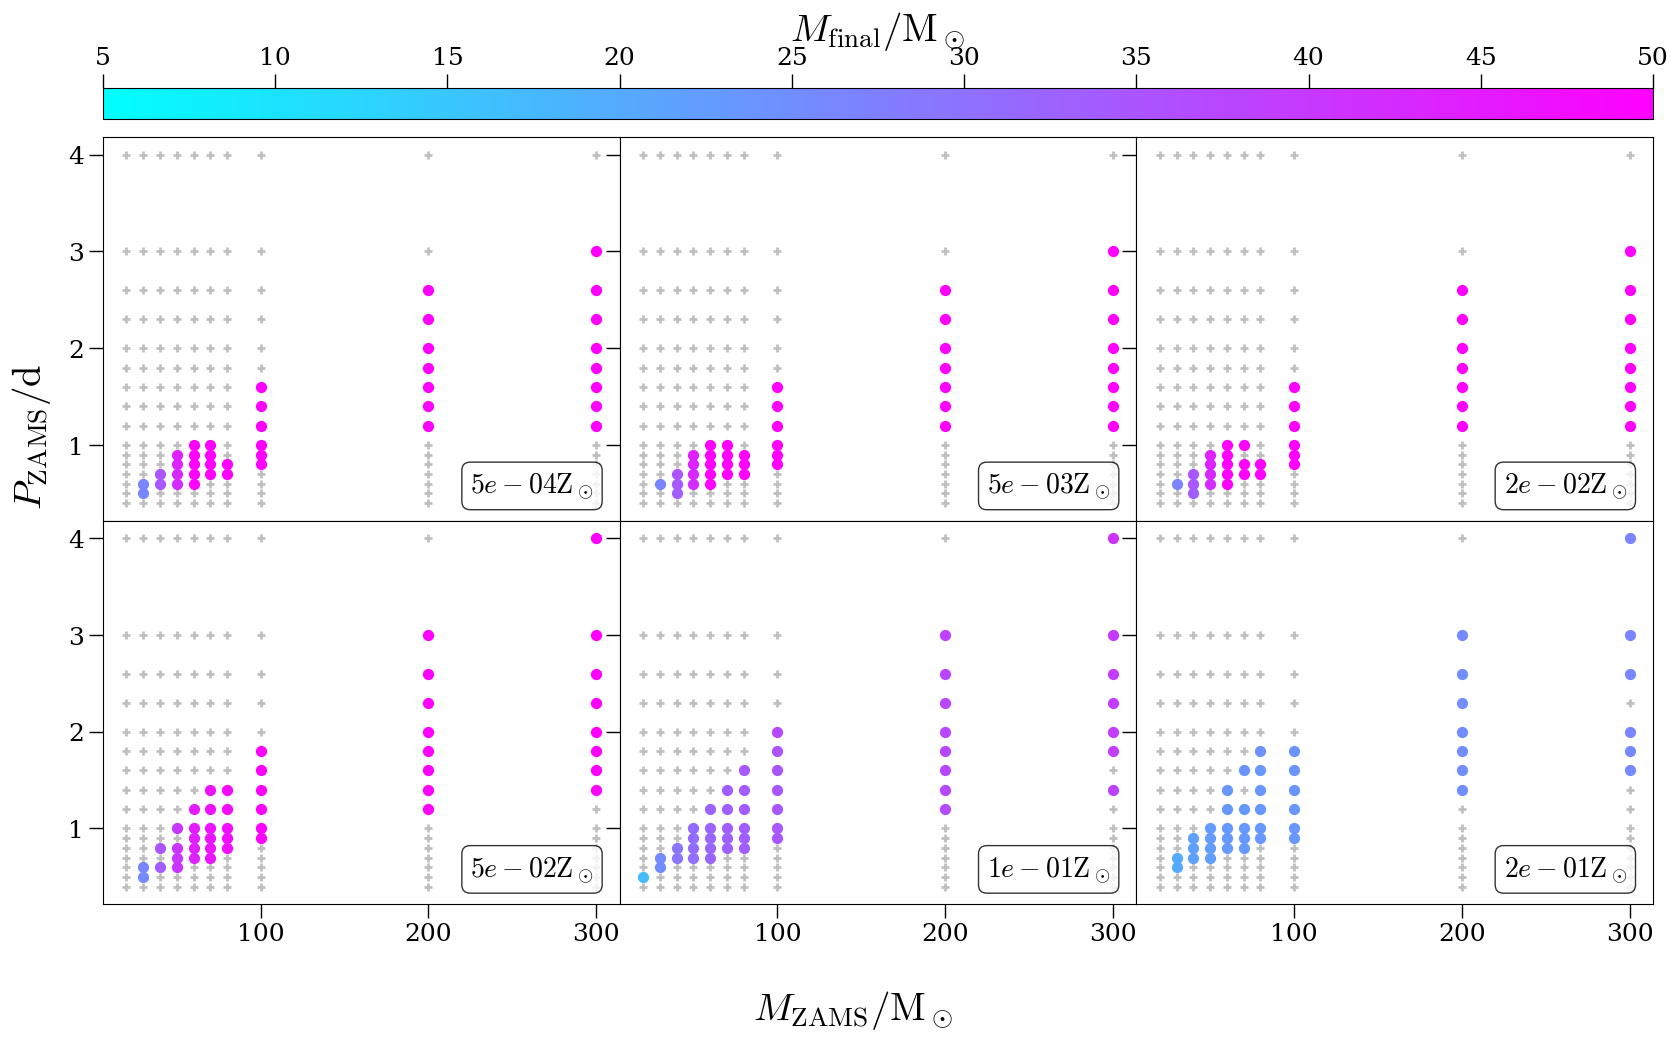

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
cvar = 'm_final'
cmap = cm.cool
cmin = 5
cmax = 50
darkening_factor = 0.5
pie_size = 50
highlight_mergers = False

guide_z_str = list(final_core_prop_array_dict.keys())
labelbox_props = dict(boxstyle='round', facecolor='white', alpha=0.8)

for i, (z_div_zsun, ax) in enumerate(zip(guide_z_str, axes.flatten())):
    ax = ms_score_pie_scatter(
        i=i,
        z_div_zsun=z_div_zsun,
        ax=ax,
        cvar=cvar,
        cmap=cmap,
        cmin=cmin,
        cmax=cmax,
        darkening_factor=darkening_factor,
        pie_size=pie_size,
        highlight_mergers=highlight_mergers
    )
    
    ax.text(0.95, 0.05, f'${float(z_div_zsun):.0e}\mathrm{{Z}}_\odot$', transform=ax.transAxes,
            ha='right', va='bottom', fontsize=20, bbox=labelbox_props)
    
fig.text(0.1, 0.5, '$P_\mathrm{ZAMS}/\mathrm{d}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.04, '$M_\mathrm{ZAMS}/\mathrm{M}_\odot$', ha='center', va='top', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=cmin, vmax=cmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', pad=0.02, aspect=50, location='top')
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$M_\mathrm{final}/\mathrm{M}_\odot$')

#savefig(fig, 'ms_score_pie_mfinal_panels')